In [1]:
import numpy as np
from keras.models import load_model
from keras.layers import Conv2D, LocallyConnected2D
from keras import Sequential
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from matplotlib.axes import Axes
from matplotlib.figure import Figure

In [2]:
FCN_FILENAME = 'SavedModels/trained_fcn.h5'
CNN_FILENAME = 'SavedModels/model.h5'

In [3]:
fcn: Sequential = load_model(FCN_FILENAME)
fcn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected2d_3 (Loca  (None, 14, 14, 64)       953344    
 llyConnected2D)                                                 
                                                                 
 locally_connected2d_4 (Loca  (None, 5, 5, 128)        5123200   
 llyConnected2D)                                                 
                                                                 
 locally_connected2d_5 (Loca  (None, 3, 3, 256)        2656512   
 llyConnected2D)                                                 
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                      

In [4]:
cnn: Sequential = load_model(CNN_FILENAME)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 2,875,530
Trainable params: 2,875,530
Non-

In [5]:
def get_layer_distances(cnn_layer: Conv2D, fcn_layer: LocallyConnected2D) -> np.ndarray:
    cnn_weights: np.ndarray = cnn_layer.get_weights()[0]
    fcn_weights: np.ndarray = fcn_layer.get_weights()[0]
    
    flattened_filter_size: int = cnn_weights.shape[0] * \
                                 cnn_weights.shape[1] * \
                                 cnn_weights.shape[2]
    flattened_filters: np.ndarray = cnn_weights.reshape((
        flattened_filter_size,
        cnn_weights.shape[3]
    ))
    flattened_duplicated_filters: np.ndarray = np.empty(fcn_weights.shape)
    for i in range(fcn_weights.shape[0]):
        flattened_duplicated_filters[i, :, :] = flattened_filters[:, :]

    cosine_distances: np.ndarray = np.empty((fcn_weights.shape[0], fcn_weights.shape[2]))
    for i in range(fcn_weights.shape[0]):
        for j in range(fcn_weights.shape[2]):
            cosine_distances[i, j] = cosine(
                fcn_weights[i, :, j],
                flattened_duplicated_filters[i, :, j]
            )
    return cosine_distances

In [6]:
layer_distances: list[list[any]] = []
for i in range(len(cnn.layers)):
    if isinstance(cnn.layers[i], Conv2D):
        dists: np.ndarray = get_layer_distances(cnn.layers[i], fcn.layers[i])
        layer_distances.append([i, dists.flatten()])

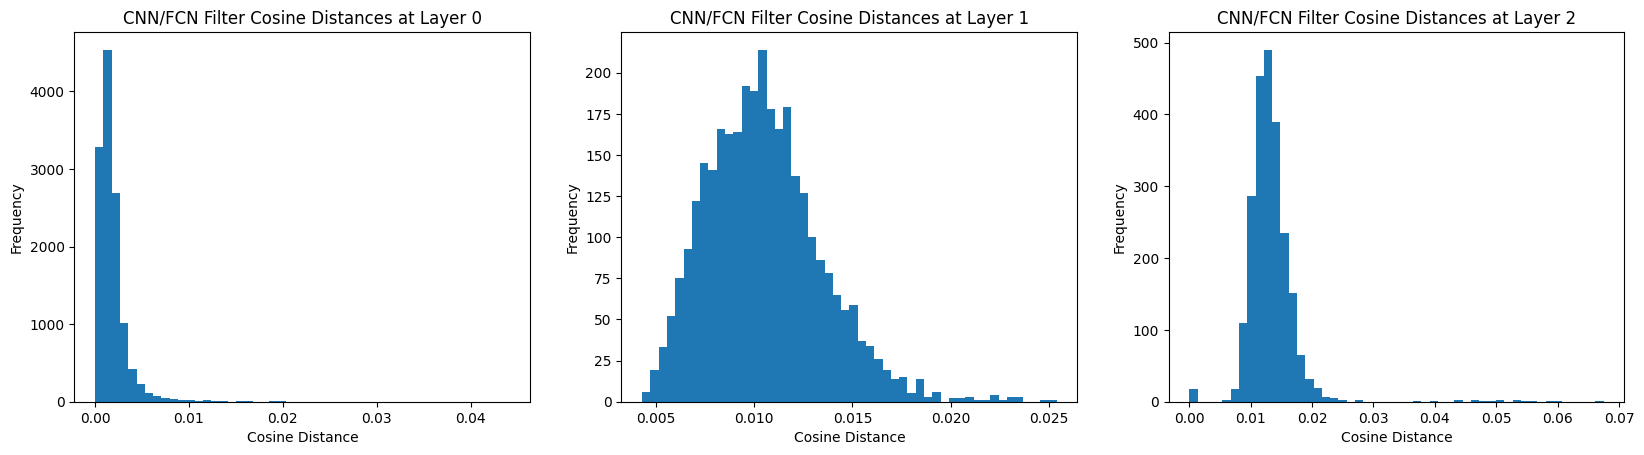

In [9]:
hist_fig: Figure; hist_axs: tuple[Axes, ...]
hist_fig, hist_axs = plt.subplots(1, len(layer_distances))
hist_fig.set_figwidth(20)
for i in range(len(layer_distances)):
    hist_axs[i].hist(layer_distances[i][1], bins=50)
    hist_axs[i].set_ylabel("Frequency")
    hist_axs[i].set_xlabel("Cosine Distance")
    hist_axs[i].set_title(f"CNN/FCN Filter Cosine Distances at Layer {i}")
plt.show()